# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '../../../../Downloads/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

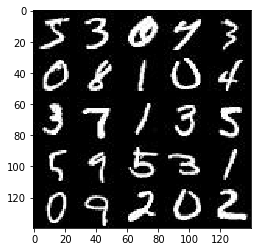

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

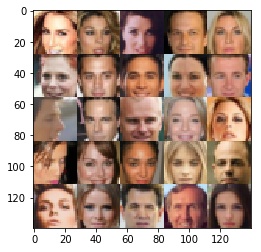

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_images')
    z_data = tf.placeholder(tf.float32, shape = [None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [38]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(alpha * x3, x3)
        # 3x3x256
        
        flat = tf.reshape(x3, (-1, 3*3*256) )
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')  # valid -> size: 2 * 3 + 1
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # generator 
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                batch_i += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
               # _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                # show stats every 10 batches
                if batch_i % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # show images every 100 batches
                if batch_i % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    
            # end of Epoch images
            print('State of the art after epoch', epoch_i+1)
            show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.7353
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.6940
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.8294
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 0.9772
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.8576
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.8734


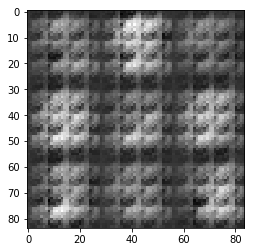

Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.8471
Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.9997
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 1.4184
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 1.1661
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.8861


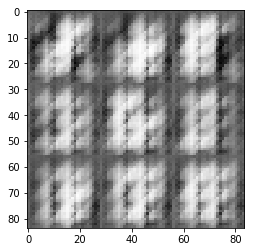

Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 1.0500
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.6023... Generator Loss: 0.9398
Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 1.6274... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.8994
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.5973
Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 1.4948
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 1.1603


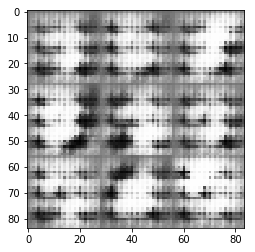

Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.2584
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 1.1156
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 1.4067
Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 1.3203
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 0.9422
Epoch 1/2... Discriminator Loss: 1.6111... Generator Loss: 0.6849
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.9067
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 1.2682
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 1.2850


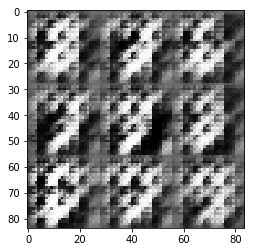

Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.9272
Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 1.1219
Epoch 1/2... Discriminator Loss: 0.8490... Generator Loss: 1.3042
Epoch 1/2... Discriminator Loss: 1.6241... Generator Loss: 1.6394
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 1.1542
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 1.3586
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 1.0304


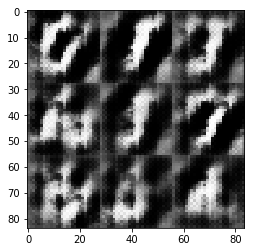

Epoch 1/2... Discriminator Loss: 1.0495... Generator Loss: 1.2338
Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 1.0121
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.2397
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.8941
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 0.9972
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.2137
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 1.0832


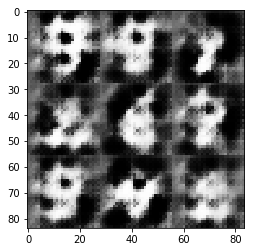

Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 1.0589
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.9572
Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 0.9641
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.8152


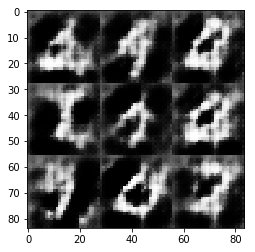

Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 1.4147
Epoch 1/2... Discriminator Loss: 1.2596... Generator Loss: 1.0288
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 1.0324
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 1.0325
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 0.9511
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.9146


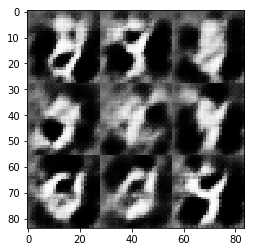

Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 0.9997
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.0836... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.9796
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.9561
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.7761
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.9245


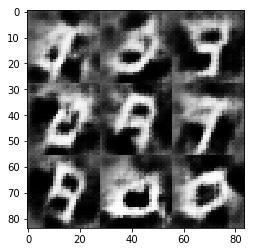

Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.9181
State of the art after epoch 1


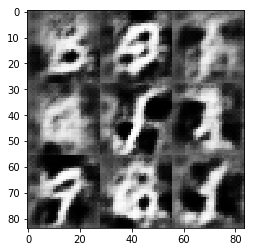

Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.9441
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.8863
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 0.8784
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.8871
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 1.1169
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 0.9506


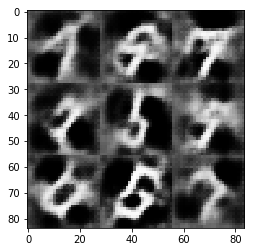

Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.8159
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 1.2101... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.7755
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 0.8621
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.8181


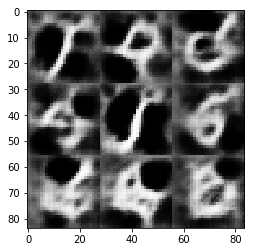

Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.8237
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.8073


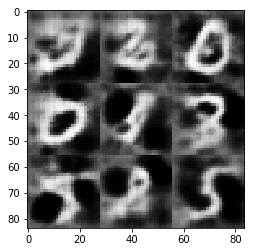

Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.8672
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 0.9829
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.9961


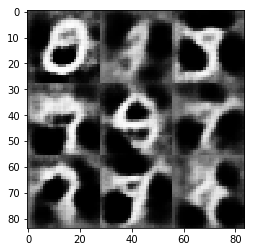

Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.9381
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.8116
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.7627
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 1.0534
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 0.8773


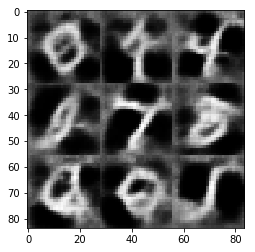

Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.9440
Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.8378
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.9365


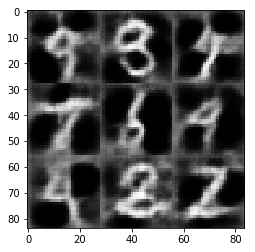

Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 1.1756
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.8743
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.8609
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.8603


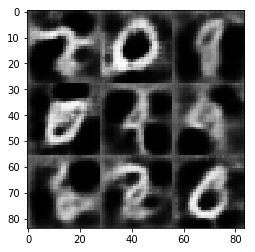

Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.7733
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 1.0699
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.8934


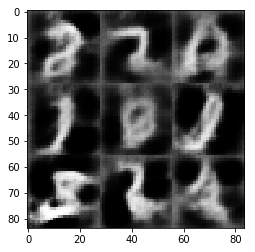

Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 1.0842
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.9391
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.9669
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.9283
Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 0.8676


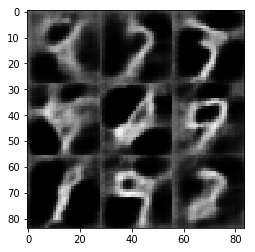

Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.9295
Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.6845
Epoch 2/2... Discriminator Loss: 1.4413... Generator Loss: 0.6062
State of the art after epoch 2


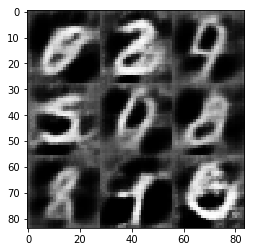

In [50]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7976


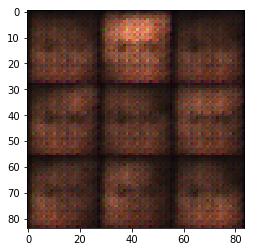

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7282


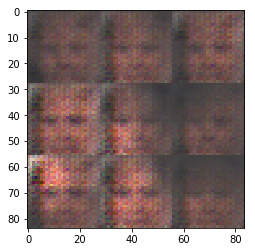

Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8483


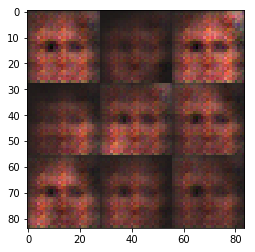

Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8543


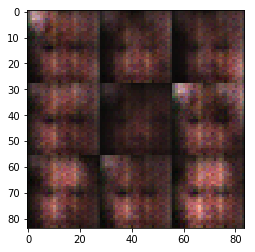

Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.9364


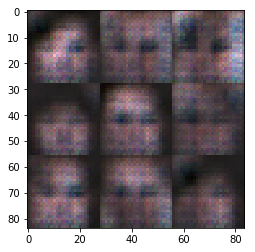

Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7825


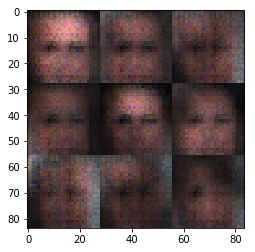

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.9296


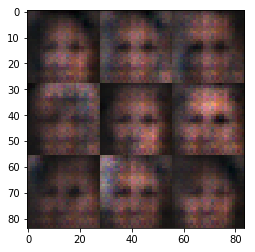

Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.8734


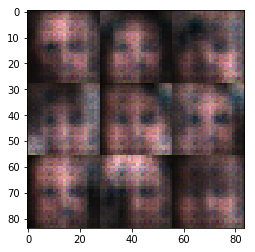

Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 1.8459
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.8036


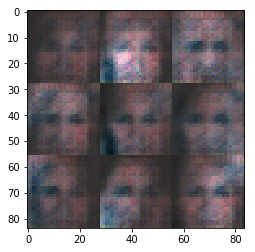

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.9090
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8127


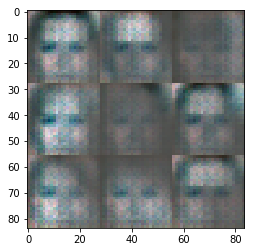

Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 1.0410


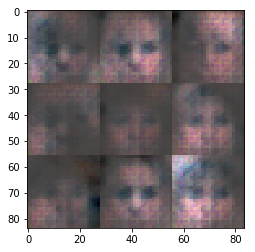

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.3333


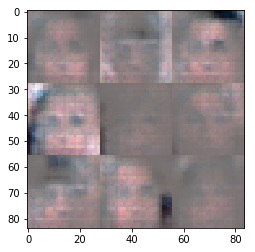

Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8002


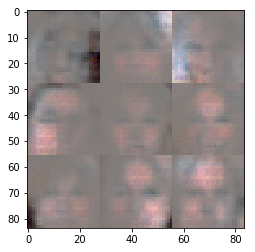

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8472


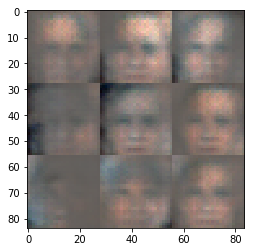

Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.9367


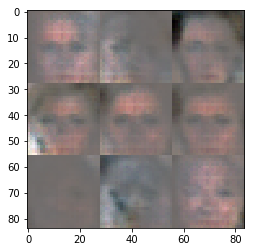

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8654


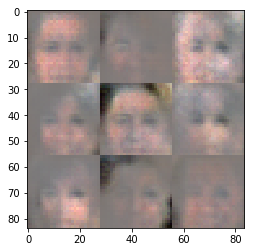

Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8058


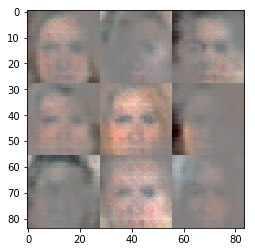

Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8606


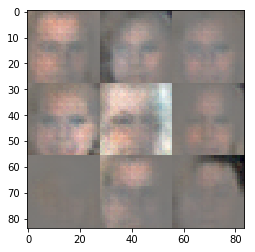

Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8005


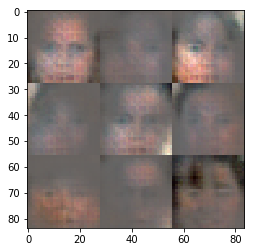

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8025


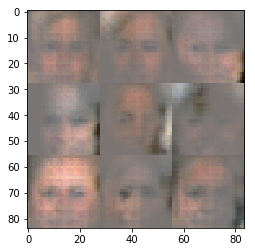

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8986


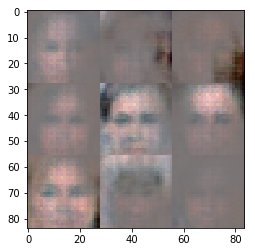

Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9929


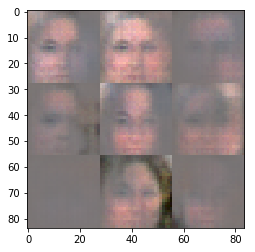

Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8209


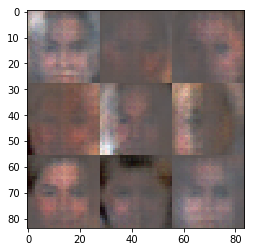

Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.9043


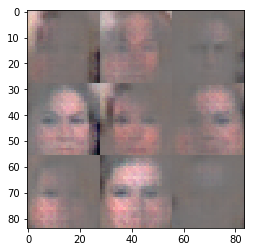

Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.9288


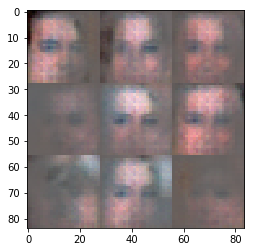

Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8245


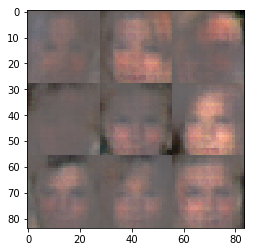

Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 1.7806
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8161


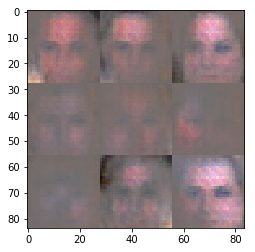

Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8251


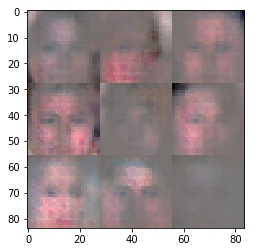

Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.8141


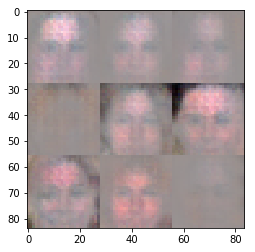

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8247


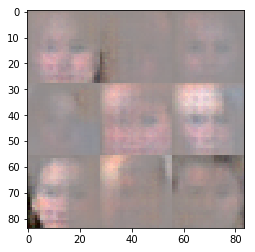

Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8371


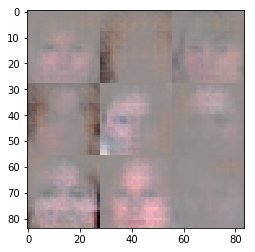

Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8030
State of the art after epoch 1


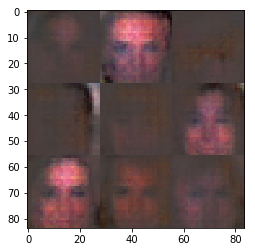

In [51]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.